In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

from DataProc.DataProcessor import DataProcessor
from Datasets.BaseballDataset import BaseballDataset
from BaselineModel.BaselineModel import BaselineModel
from TransformerModel.TransformerModelRedisual import *

import torch
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional as F
from torch.utils.data import DataLoader
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

In [16]:
data_config_path = "../../data/configv2.json"
full_data_path = "../../data/full_cleaned_zone_93.csv"
full_data = pd.read_csv(full_data_path)

In [90]:
sequence_length = 400

In [91]:
#for each zone for pitch location and each hit_location, we need to calculate average coords to fill our examples with
# hc_x, hc_y #hit coords
# plate_x, plate_z #pitch coords

hit_coords_means = dict()
hit_loc_cols = [col for col in full_data.columns if col.startswith('hit_location')]

pitch_coords_means = dict()
zone_cols = [col for col in full_data.columns if col.startswith('zone')]



for col in hit_loc_cols:
    hc_x_mean = full_data[full_data[col] == True]['hc_x'].mean()
    hc_y_mean = full_data[full_data[col] == True]['hc_y'].mean()

    hit_coords_means[col] = (hc_x_mean,hc_y_mean)

for col in zone_cols:
    plate_x_mean = full_data[full_data[col] == True]['plate_x'].mean()
    plate_z_mean = full_data[full_data[col] == True]['plate_z'].mean()

    pitch_coords_means[col] = (plate_x_mean,plate_z_mean)

C:\Users\declan\AppData\Local\Temp\ipykernel_11864\1999053017.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(zone_dict))
C:\Users\declan\AppData\Local\Temp\ipykernel_11864\1999053017.py:34: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x_mean, z_mean, color=colors(i), edgecolor='black', s=100, marker='x')


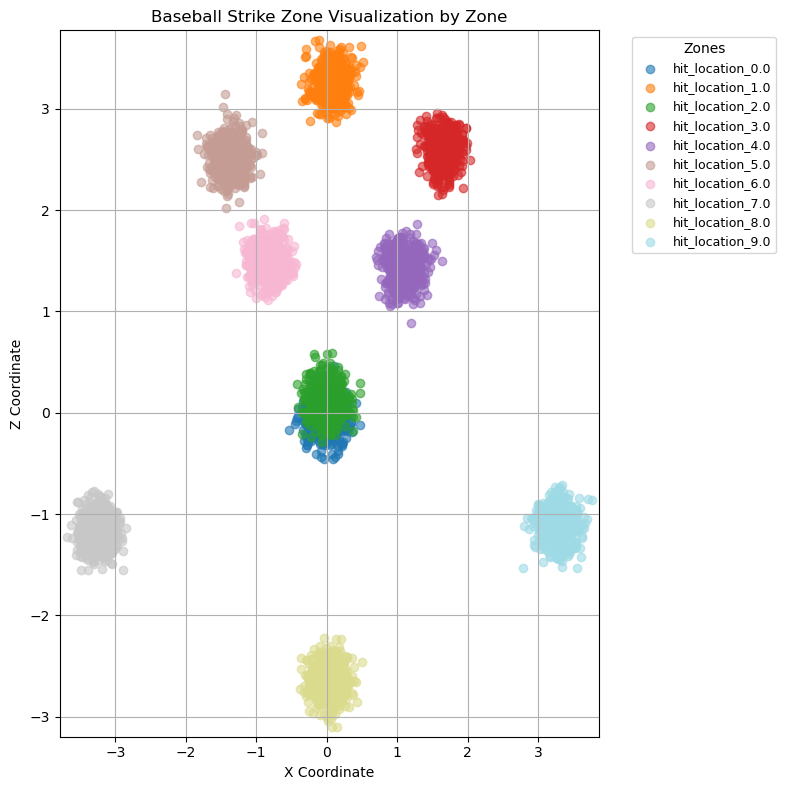

In [89]:
#sanity check

# Strike zone data
zone_dict = hit_coords_means

# Increase the number of sample points and standard deviation
n_samples = 500
std_dev = 0.15

# Initialize lists to store all sampled points
all_x_samples = []
all_z_samples = []

# Generate the plot
plt.figure(figsize=(8, 8))

# Set different colors for each zone
colors = plt.cm.get_cmap('tab20', len(zone_dict))

# Loop through each zone and generate random points around the mean (x, z)
for i, (zone, (x_mean, z_mean)) in enumerate(zone_dict.items()):
    # Sample points around the mean using normal distribution with increased std_dev
    x_samples = np.random.normal(loc=x_mean, scale=std_dev, size=n_samples)
    z_samples = np.random.normal(loc=z_mean, scale=std_dev, size=n_samples)
    
    # Add sampled points to lists
    all_x_samples.extend(x_samples)
    all_z_samples.extend(z_samples)
    
    # Plot each zone's points with a different color
    plt.scatter(x_samples, z_samples, color=colors(i), label=zone, alpha=0.6)

    # Optionally, plot the zone mean point as a large dot
    plt.scatter(x_mean, z_mean, color=colors(i), edgecolor='black', s=100, marker='x')

# Label the axes and add legend
plt.xlabel('X Coordinate')
plt.ylabel('Z Coordinate')
plt.title('Baseball Strike Zone Visualization by Zone')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Zones", fontsize=9)
plt.grid(True)

# Get the min and max values of all sampled points to set the axis limits
x_min, x_max = min(all_x_samples), max(all_x_samples)
z_min, z_max = min(all_z_samples), max(all_z_samples)

# Adjust axis limits based on min/max values
plt.xlim(x_min - 0.1, x_max + 0.1)  # Adding a small buffer to the limits
plt.ylim(z_min - 0.1, z_max + 0.1)

# Display the plot
plt.tight_layout()
plt.show()

In [25]:
scaler_path = "../../data/full_scalers_zone_93.pkl"
with open(scaler_path, "rb") as file:
    scalers = pickle.load(file)

c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [92]:
start_date = "2022-06-01" #date from which new examples will be added
player = "aaron judge"

#get previous (sequence_length) pitches for this player starting at start_date
filtered_data = full_data[(full_data['batter_name'] == player) & (full_data['game_date'] <= start_date)].sort_values(by=['game_date']).tail(sequence_length)









In [28]:
pitcher = "dylan cease"
pitcher_context_size = 2000 #abitrary for now
pitcher_data = full_data[(full_data['pitcher_name'] == pitcher) & (full_data['game_date'] <= start_date)].sort_values(by=['game_date']).tail(pitcher_context_size)



In [29]:
pitcher_data

,launch_speed,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,pfx_x,pfx_z,plate_x,...,balls_1,balls_2,balls_3,balls_4,strikes_0,strikes_1,strikes_2,outs_when_up_0,outs_when_up_1,outs_when_up_2
2168713,-0.440642,2021-07-27,-0.614620,-0.643937,0.654450,656811,656302,0.844462,-0.970858,-0.148691,...,False,False,True,False,False,False,True,True,False,False
2168744,-0.602708,2021-07-27,1.295020,-0.232476,1.038679,521692,656302,-0.139710,1.092012,1.253316,...,False,True,False,False,True,False,False,False,False,True
2168711,1.454284,2021-07-27,-0.332325,-0.749440,0.558393,656811,656302,0.471155,-0.836906,0.295278,...,False,False,True,False,False,False,True,True,False,False
2168712,-0.527908,2021-07-27,1.328232,-0.622836,0.865776,656811,656302,-0.298082,1.025035,0.482212,...,False,False,True,False,False,False,True,True,False,False
2168677,-0.002705,2021-07-27,-0.249297,-0.596461,0.443124,467793,656302,0.867087,-1.211973,1.007965,...,True,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658814,-0.002705,2022-05-29,-0.182875,-0.396006,0.846564,664731,656302,0.618216,-0.850301,0.785980,...,False,True,False,False,True,False,False,False,False,True
1658815,-0.002705,2022-05-29,1.494287,-0.332704,1.077102,664731,656302,0.278846,0.998245,0.867764,...,True,False,False,False,True,False,False,False,False,True
1658816,-0.002705,2022-05-29,-0.249297,-0.411831,0.808142,664731,656302,0.584279,-1.185183,1.346783,...,False,False,False,False,True,False,False,False,False,True
1658795,1.329618,2022-05-29,1.510893,-0.396006,1.038679,664023,656302,-0.162335,0.703549,-0.791278,...,True,False,False,False,False,False,True,False,False,True


In [31]:
pitch_stat_cols = ['release_speed', 'release_pos_x','release_pos_z','pfx_x', 'pfx_z', 'plate_x','plate_z', 'hc_x', 'hc_y', 'vy0',
                    'vz0', 'ax', 'ay', 'az', 'sz_top','sz_bot', 'release_spin_rate', 'release_extension', 'release_pos_y']

pitch_type_cols = ['pitch_type_CH', 'pitch_type_CS',
       'pitch_type_CU', 'pitch_type_EP', 'pitch_type_FA', 'pitch_type_FC',
       'pitch_type_FF', 'pitch_type_FO', 'pitch_type_FS', 'pitch_type_KC',
       'pitch_type_KN', 'pitch_type_PO', 'pitch_type_SC', 'pitch_type_SI',
       'pitch_type_SL', 'pitch_type_ST', 'pitch_type_SV']

batter_stat_cols = []








In [32]:
pitcher_pitch_stats = dict()

for pitch_type in pitch_type_cols:

    if pitcher_data[pitch_type].sum() > 0:

        #get data for all pitches with this pitch type, and get the mean for each necessary stat column
        means_dict = pitcher_data[pitcher_data[pitch_type] == True][pitch_stat_cols].mean().to_dict()

        #save means dict for this pitch_type to dict for this pitcher
        pitcher_pitch_stats[pitch_type] = means_dict


In [33]:
pitcher_data.columns

Index(['launch_speed', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'batter', 'pitcher', 'pfx_x', 'pfx_z', 'plate_x',
       'plate_z', 'hc_x', 'hc_y', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top',
       'sz_bot', 'launch_angle', 'release_spin_rate', 'release_extension',
       'game_pk', 'release_pos_y', 'at_bat_number', 'batter_name',
       'pitcher_name', 'events_B', 'events_S', 'events_double',
       'events_field_out', 'events_hit_by_pitch', 'events_home_run',
       'events_single', 'events_strikeout', 'events_triple', 'events_walk',
       'zone_1.0', 'zone_2.0', 'zone_3.0', 'zone_4.0', 'zone_5.0', 'zone_6.0',
       'zone_7.0', 'zone_8.0', 'zone_9.0', 'zone_11.0', 'zone_12.0',
       'zone_13.0', 'zone_14.0', 'pitch_type_CH', 'pitch_type_CS',
       'pitch_type_CU', 'pitch_type_EP', 'pitch_type_FA', 'pitch_type_FC',
       'pitch_type_FF', 'pitch_type_FO', 'pitch_type_FS', 'pitch_type_KC',
       'pitch_type_KN', 'pitch_type_PO', 'pitch_type_SC', 'pitch

In [142]:
#pitch info should be dict/json with user input info about the pitch, basically all info not included in pitch_stats, these are not standardized as well

pL = pitcher_data.iloc[0]['p_throws_L']
pR = pitcher_data.iloc[0]['p_throws_R']

pitch_info = {

    'launch_speed': 100,
    'batter': 0, #filler metadata, not important
    'pitcher': 0, #filler metadata, not important
    'launch_angle': 75,
    'game_pk' : 0, #filler metadata, not important
    'batter_name': player,
    'pitcher_name': pitcher,
    'event': 'events_S', #should contain the name of the column which should be true
    'zone': 1, #should contain the zone number for the pitch location 
    'pitch_type': 'pitch_type_FF', #should contain column name for pitch_type, this should only be a pitch that this pither throws
    'p_throws_L': pL,
    'p_throws_R': pR,
    'hit_location': 0, #hit_location that should be true
    'balls': 3, #number of balls pre-pitch
    'strikes': 0, #number of strikes pre-pitch
    'outs': 0 #number of outs pre-pitch


}

In [83]:

def make_pitch(pitch_stats, pitch_info, pitch_coord_means, hit_coord_means, scalers):

    #check pitcher throws this type of pitch

    if pitch_info['pitch_type'] not in pitch_stats:
        raise Exception(f"Pitcher does not throw pitch type: {pitch_info['pitch_type']}")
    

    #create copy of single batter pitch
    new_pitch = filtered_data.iloc[[0]].copy()


    #populate with mean pitch stats for this specific pitch/pitcher
    for key, val in pitch_stats[pitch_info['pitch_type']].items():
        new_pitch[key] = val
    

    #populate new pitch with use scaled input info
    for key, val in pitch_info.items():

        #check of the key is a pitch column - we have to handle the one-hot encoded ones seperately
        if key not in new_pitch.columns:
            continue

        if key == 'launch_speed' or key == 'launch_angle': #it needs scaling
            scaler = scalers[key]
            
            val = (val - scaler.mean_) / scaler.scale_
        
        new_pitch[key] = val
    

    #for hc_x, hc_y, plate_x, plate_z use the mean coordinates for the selected zone/hit location
    hc_x, hc_y = hit_coord_means[f"hit_location_{pitch_info['hit_location']}.0"]
    plate_x, plate_z = pitch_coord_means[f"zone_{pitch_info['zone']}.0"]

    new_pitch['hc_x'] = hc_x
    new_pitch['hc_y'] = hc_y
    new_pitch['plate_x'] = plate_x
    new_pitch['plate_z'] = plate_z

    
    #handle categorical ones seperately, this is terribly ugly but its fine
    for col in new_pitch.columns:
        if col.startswith('events_'):

            if col == pitch_info['event']:
                new_pitch[col] = True
            else:
                new_pitch[col] = False
    
        elif col.startswith('zone_'):

            if col == f"zone_{pitch_info['zone']}.0":
                new_pitch[col] = True
            else:
                new_pitch[col] = False

        elif col.startswith('pitch_type_'):

            if col == pitch_info['pitch_type']:
                new_pitch[col] = True
            else:
                new_pitch[col] = False
        
        elif col.startswith('hit_location_'):

            if col == f"hit_location_{pitch_info['hit_location']}.0":
                new_pitch[col] = True
            else:
                new_pitch[col] = False
        
        elif col.startswith('balls_'):

            if col == f"balls_{pitch_info['balls']}":
                new_pitch[col] = True
            else:
                new_pitch[col] = False

        elif col.startswith('strikes_'):

            if col == f"strikes_{pitch_info['strikes']}":
                new_pitch[col] = True
            else:
                new_pitch[col] = False

        elif col.startswith('outs_when_up'):

            if col == f"outs_when_up_{pitch_info['outs']}":
                new_pitch[col] = True
            else:
                new_pitch[col] = False
        
    return new_pitch







    

In [94]:
new_pitch = make_pitch(pitcher_pitch_stats, pitch_info, pitch_coords_means, hit_coords_means, scalers)
new_pitch

,launch_speed,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,pfx_x,pfx_z,plate_x,...,balls_1,balls_2,balls_3,balls_4,strikes_0,strikes_1,strikes_2,outs_when_up_0,outs_when_up_1,outs_when_up_2
1738348,2.090082,2022-05-08,1.364495,-0.336519,0.998107,0,0,-0.192701,1.238811,-0.657235,...,False,False,True,False,True,False,False,True,False,False


In [104]:
filtered_data

,launch_speed,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,pfx_x,pfx_z,plate_x,...,balls_1,balls_2,balls_3,balls_4,strikes_0,strikes_1,strikes_2,outs_when_up_0,outs_when_up_1,outs_when_up_2
1738348,-1.550171,2022-05-09,0.913092,1.344790,0.308644,592450,656271,0.912336,0.958059,-0.172058,...,False,True,False,False,False,True,False,False,True,False
1738349,-0.002705,2022-05-09,1.029331,1.360615,0.385490,592450,656271,1.115958,1.386707,-0.616027,...,True,False,False,False,False,True,False,False,True,False
1738346,-0.002705,2022-05-09,0.962909,1.365890,0.616027,592450,656271,1.636324,1.239359,0.026560,...,False,False,True,False,False,False,True,False,True,False
1738263,2.214748,2022-05-09,0.697220,1.328964,1.153948,592450,656685,0.618216,-0.073376,0.914498,...,True,False,False,False,False,False,True,False,True,False
1738266,-0.002705,2022-05-09,-1.212420,1.234012,1.307639,592450,656685,-0.241521,-2.430942,0.061610,...,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1650371,-0.002705,2022-05-31,0.996120,0.010180,0.251010,592450,592789,-0.230209,0.824106,1.031331,...,False,False,True,False,True,False,False,False,True,False
1650373,-0.002705,2022-05-31,0.082814,0.031281,0.231798,592450,592789,-1.169131,0.020391,0.984598,...,True,False,False,False,True,False,False,False,True,False
1650374,-0.002705,2022-05-31,-0.382142,-0.074222,0.347067,592450,592789,0.391969,-0.917277,1.019648,...,False,False,False,False,True,False,False,False,True,False
1650267,-0.002705,2022-05-31,0.713826,0.943879,-0.152431,592450,670046,0.901024,1.172383,-1.083363,...,False,False,False,False,False,False,True,False,True,False


In [143]:
from datetime import datetime, timedelta
#when adding new pitches to the filtered data, we need to make the game_date for new pitches come after the final one
#also need to increment at_bat number


new_pitches = [pitch_info, pitch_info.copy()] #list of pitches to be added, should be a list of dicts like pitch_info
sequence_data = filtered_data.copy()


curr_date = datetime.strptime(filtered_data['game_date'].max(), '%Y-%m-%d') #latest date
ab_number = 1
pitch_number = 1
for p in new_pitches:
    curr_date = curr_date + timedelta(days=1)
    p['game_date'] = curr_date.strftime('%Y-%m-%d')
    
    p['at_bat_number'] = ab_number
    ab_number += 1

    p['pitch_number'] = pitch_number
    pitch_number += 1

    sequence_data = pd.concat([sequence_data,make_pitch(pitcher_pitch_stats, p, pitch_coords_means, hit_coords_means, scalers)])

sequence_data.reset_index(drop=True, inplace=True)


In [139]:
sequence_data.columns

Index(['launch_speed', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'batter', 'pitcher', 'pfx_x', 'pfx_z', 'plate_x',
       'plate_z', 'hc_x', 'hc_y', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top',
       'sz_bot', 'launch_angle', 'release_spin_rate', 'release_extension',
       'game_pk', 'release_pos_y', 'at_bat_number', 'batter_name',
       'pitcher_name', 'events_B', 'events_S', 'events_double',
       'events_field_out', 'events_hit_by_pitch', 'events_home_run',
       'events_single', 'events_strikeout', 'events_triple', 'events_walk',
       'zone_1.0', 'zone_2.0', 'zone_3.0', 'zone_4.0', 'zone_5.0', 'zone_6.0',
       'zone_7.0', 'zone_8.0', 'zone_9.0', 'zone_11.0', 'zone_12.0',
       'zone_13.0', 'zone_14.0', 'pitch_type_CH', 'pitch_type_CS',
       'pitch_type_CU', 'pitch_type_EP', 'pitch_type_FA', 'pitch_type_FC',
       'pitch_type_FF', 'pitch_type_FO', 'pitch_type_FS', 'pitch_type_KC',
       'pitch_type_KN', 'pitch_type_PO', 'pitch_type_SC', 'pitch

In [133]:
new_dataset = BaseballDataset(sequence_data, data_config_path, sequence_length)

In [134]:
len(new_dataset)

0